## Computing Topological Features of Embedding Point Clouds

In [1]:
from _collections_abc import Iterable

import glob
import re
import json

import gudhi
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [2]:
def parse_json_filename(filename:str) -> tuple[str, list[tuple[str]]]:
    '''
    Parse JSON filesnames produced by CodeEmbeddingsGenerator.py
    into the classes, methods, and tokens they are located in.

    Args:
        filename: JSON filename to parse.
    
    Returns:
        level: Coding level of granularity (i.e., "class", "method", "token")
        identifiers: An ordered list of the nested classes, methods, and/or token.
    '''
    f = filename[:-5]
    nesting = []
    for m in re.finditer(r'(^|_)(c\.|m\.|token)', f):
        if (m.group() == 'c.') or (m.group() == '_c.'): level = 'class'
        elif (m.group() == 'm.') or (m.group() == '_m.'): level = 'method'
        elif (m.group() == 'token') or (m.group() == '_token'): level = 'token'
        else:
            print(f'Something has gone wrong! \n\tFilename: {filename}\n\tMatch: {m}')
            level = ''

        nesting.append((m.start(), m.end(), level))

    identifiers = []
    for i in range(1, len(nesting)):
        end = nesting[i]
        start = nesting[i-1]

        # Get identifier name and duplicate number 
        # (or just duplicate number if its a token)
        name = f[start[1] : end[0]]
        identifiers.append((name, start[2])) # Store name and level

    # Get last name and level
    last = nesting[-1]
    name = f[last[1]:] 
    identifiers.append((name, last[2]))

    # Return embedding level and parsing results
    return last[2], identifiers


def get_embedding_paths(sub_dirs:list[str] = ['data'], 
                        levels:list[str] = ['class', 'method', 'token'],
                        id_nestings:list[tuple[str]] = []
                        ) -> tuple[list[str], list[str]]:
    '''
    Return file paths for JSON files created by CodeEmbeddingsGenerator.py.
    Collects all JSON files in a data folder by default.

    sub_dirs: Paths to subdirectories within the data folder to collect the JSON files from.
    levels: Embedding levels to collect (i.e., "class", "method", "token").
    id_nestings: Ordered lists of classes and/or methods that the code fragments associated with 
        the embeddings must be found in. The format must match that of the the 2nd output of 
        parse_json_filename().

    Returns:
        embed_paths: Paths to the JSON files.
        embed_levels: Embedding levels associated with each path in embed_paths.
    '''
    for level in levels:
        if level not in ('class', 'method', 'token'):
            print(f'Warning: Invalid level name "{level}".')
            
    embed_paths = []
    embed_levels = []
    for dir in sub_dirs:
        # Search through all JSON files
        for path in glob.glob(dir + '/**/*.json', recursive=True):
            filename = re.split(r'\\|/', path)[-1] # Get filename (and file extension)
            level, identifiers = parse_json_filename(filename) # Get embedding level and the nesting
            # Collect paths to embeddings of specified levels
            if level in levels:
                if len(id_nestings) == 0:
                    embed_paths.append(path)
                    embed_levels.append(level)
                    continue
                # Collect paths to embeddings that are nested in the specified classes and/or methods
                for nesting in id_nestings:
                    if nesting == identifiers[:len(nesting)]:
                        embed_paths.append(path)
                        embed_levels.append(level)
                        break
    return embed_paths, embed_levels


def paths_to_data(paths:Iterable[str]) -> dict:
    '''
    Takes a list of directory paths to JSON files generated by CodeEmbeddingsGenerator.py, 
    then loads the data and compiles them into a single dictionary.

    Args:
        paths: The list of directory paths to JSON files.

    Returns:
        data: A dataset of embeddings, the associated identifier/token name, 
            the start and end indices for parsing the original code fragment,
            and the directory path to the JSON file.
    '''
    data = {'embeds':list(), 'names':list(), 'spans':list(), 'paths':list()}
    for path in paths:
        file = json.load(open(path, 'r'))
        data['embeds'].append(file[0][0]) # Embedding
        data['names'].append(file[1]) # Identifier or token name
        data['spans'].append(file[2]) # Start and end indices in source code
        data['paths'].append(path) # Path to file
    return data

### Methods in Each Java File

In [9]:
paths, _ = get_embedding_paths(sub_dirs=['data/ivy/ant/ConvertManifestTask'], levels=['method'])
data = paths_to_data(paths)

In [20]:
tree = gudhi.RipsComplex(points=data['embeds'], max_edge_length=45).create_simplex_tree(max_dimension=3)
persist = tree.persistence(homology_coeff_field=46337)
tree.betti_numbers()

[3]

In [21]:
persist

[(0, (0.0, inf)),
 (0, (0.0, inf)),
 (0, (0.0, inf)),
 (0, (0.0, 43.671446181222365))]

True

/home/cxiong/.conda/envs/ant-ivy-2/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:112: UserWarning: usetex mode requires dvipng.
  warnings.warn("usetex mode requires dvipng.")


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

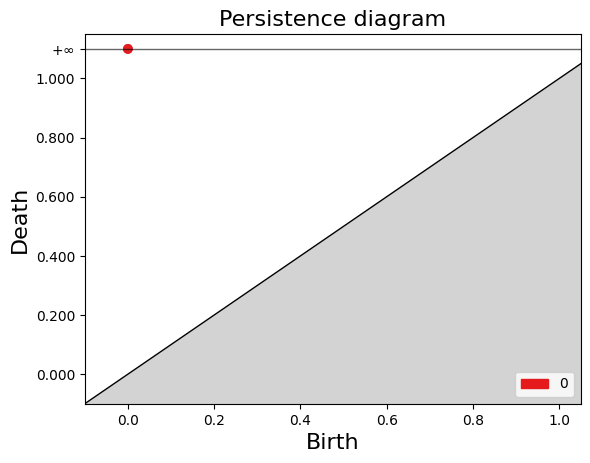

In [11]:
gudhi.plot_persistence_diagram(persist)

In [22]:
# Set of all directories to folders of JSON files
all_java_files = list(set(['/'.join(dir.split('/')[:-1]) for dir in glob.glob("data/**/*.json", recursive=True)]))
all_java_files = sorted(all_java_files)

In [23]:
betti_nums = {}
for i, dir in enumerate(all_java_files):
    clear_output()
    print(f'Working on Java file #{i}: {dir}')
    paths, levels = get_embedding_paths(sub_dirs=[dir], levels=['method'])
    data = paths_to_data(paths)
    data['levels'] = levels

    if len(data['embeds']) == 0:
        continue
        
    tree = gudhi.RipsComplex(points=data['embeds'], max_edge_length=40).create_simplex_tree(max_dimension=3)
    persist = tree.persistence(homology_coeff_field=46337)

    if persist == [(0, (0.0, np.inf))]*len(persist):
        # This occurs when max_edge_length is too low, and simplicial complex is all verticies and no edges
        # Do not call betti_numbers(), lest the kernel crashes
        betti_nums[dir] = [len(data['embeds'])] # \beta_0 = number of embeddings
    else:        
        betti_nums[dir] = tree.betti_numbers()

Working on Java file #487: data/ivy/util/url/URLHandlerRegistry


In [24]:
betti_nums

{'data/ivy/Ivy': [5, 1, 0],
 'data/ivy/Ivy14': [3, 0, 0],
 'data/ivy/Main': [3, 0, 0],
 'data/ivy/ant/AddPathTask': [2, 0, 0],
 'data/ivy/ant/AntBuildTrigger': [3, 0, 0],
 'data/ivy/ant/AntCallTrigger': [2, 0, 0],
 'data/ivy/ant/AntMessageLogger': [1, 1, 0],
 'data/ivy/ant/AntWorkspaceResolver': [11, 0],
 'data/ivy/ant/BuildOBRTask': [9],
 'data/ivy/ant/ConvertManifestTask': [4],
 'data/ivy/ant/EmptyFileSet': [3, 1],
 'data/ivy/ant/FixDepsTask': [4],
 'data/ivy/ant/IvyAntSettings': [7, 0, 0],
 'data/ivy/ant/IvyAntVariableContainer': [2, 0],
 'data/ivy/ant/IvyArtifactProperty': [1, 0],
 'data/ivy/ant/IvyArtifactReport': [5, 0, 0],
 'data/ivy/ant/IvyBuildList': [7, 2, 0],
 'data/ivy/ant/IvyBuildNumber': [3, 0, 0],
 'data/ivy/ant/IvyCacheFileset': [4],
 'data/ivy/ant/IvyCachePath': [2, 0],
 'data/ivy/ant/IvyCacheTask': [1],
 'data/ivy/ant/IvyCheck': [3],
 'data/ivy/ant/IvyCleanCache': [3],
 'data/ivy/ant/IvyConfigure': [4, 1, 0],
 'data/ivy/ant/IvyConflict': [6],
 'data/ivy/ant/IvyConvert